# Project: Ubiquitous Computing Project 2

Date: 05.2021

Authors: 
 * Rayan Armani [rarmani@ethz.ch]
 * Massimo Albarello [malbarello@ethz.ch]

## 0. Importing data and necessary libraries


In [1]:
import pickle5 as pickle 
import numpy as np
import pandas as pd
import time
import math
from scipy import signal
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, pearsonr, skew, kurtosis
from neurokit2 import eda_phasic, eda_peaks
from tqdm.notebook import tqdm
import warnings; warnings.simplefilter('ignore')


plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


## 1. Feature extraction and data analysis

### 1.1 ECG

#### a) Plotting the PSD
The Lead I ECG signal is the difference between the sensor measurements of the left and right arms. To find its Power Spectral Density we use Welch's method such as in Abadi et al.  

References:
* [scipy.signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html)
* [Mojtaba Khomami Abadi, Ramanathan Subramanian, Seyed Mostafa Kia, Paolo Avesani, Ioannis Patras, and Nicu Sebe. Decaf: Meg-based multimodal database for decoding affective physiological responses. *IEEE Transactions on Affective Computing*, 6(3):209–222, 2015 ](https://stefan.winkler.site/Publications/tac2015.pdf)

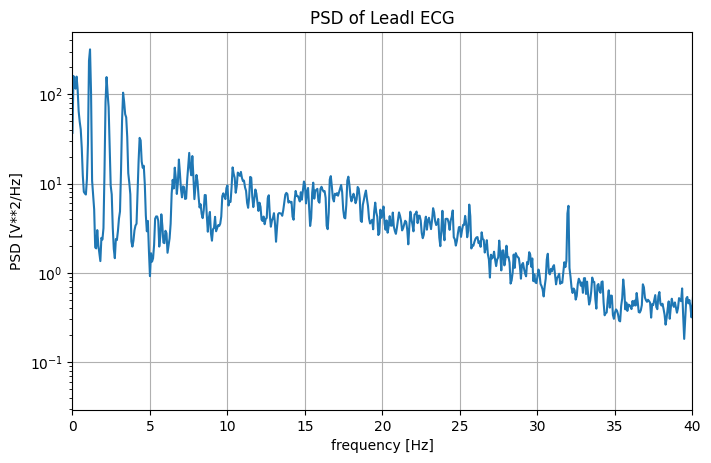

In [2]:
# Get data for the first patient
with open("ex2_recordings/participant_01.pkl", "rb") as f:
    particiapnt_01_data = pickle.load(f)
    
# Extract sampling frequency of ECG
ECG_freq = particiapnt_01_data["FS_ECG"]

# Extract Lead I ECG (left_hand - right hand) signal of the first participant watching clip 1
raw_ECG_p1 = np.array(particiapnt_01_data["recordings"][1]["ECG"])

lead1_ecg_p1= np.array(raw_ECG_p1[:,1]-raw_ECG_p1[:,2])

# Parameters for calculating the PSD 
# From [1] in exercise handout: Welch method using window length of 15xsr overlap 10xsr where sr denotes sampling rate
f, Pxx_den = signal.welch(x=lead1_ecg_p1, fs= ECG_freq, nperseg = 15*ECG_freq, noverlap= 10*ECG_freq, scaling='density', average='mean')

plt.semilogy(f, Pxx_den)
plt.xlim(0,40)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('PSD of LeadI ECG')
plt.grid(True)
plt.show()


#### b) Signal filtering

The raw Lead I ECG is inherently noisy, as shown by the presence of high frequency components as revealed in the PSD. Features of interest in an ECG however, are in the lower frequency ranges. From the PSD plot, we can infer that the signal's most significant components lie in the [0-20Hz] range. As such we can design a low pass filter to remove noise components with frequencies above 20Hz, using scipy's implementation of a Butterworth filter. When we plot the results from a simple low pass filter, we notice the baseline is not stable. To reduce the effect of a wandering baseline, we add a high pass filter at 2Hz. We can combine both filters in a bandapss filter over [4-20Hz] 
Notes: **most papers I reaad mentioned filtering with a cutoff at 20Hz ex: https://www.hindawi.com/journals/cmmm/2015/453214/

References: 
* [scipy.signal.butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html)
* [scipy repository on github](https://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass)


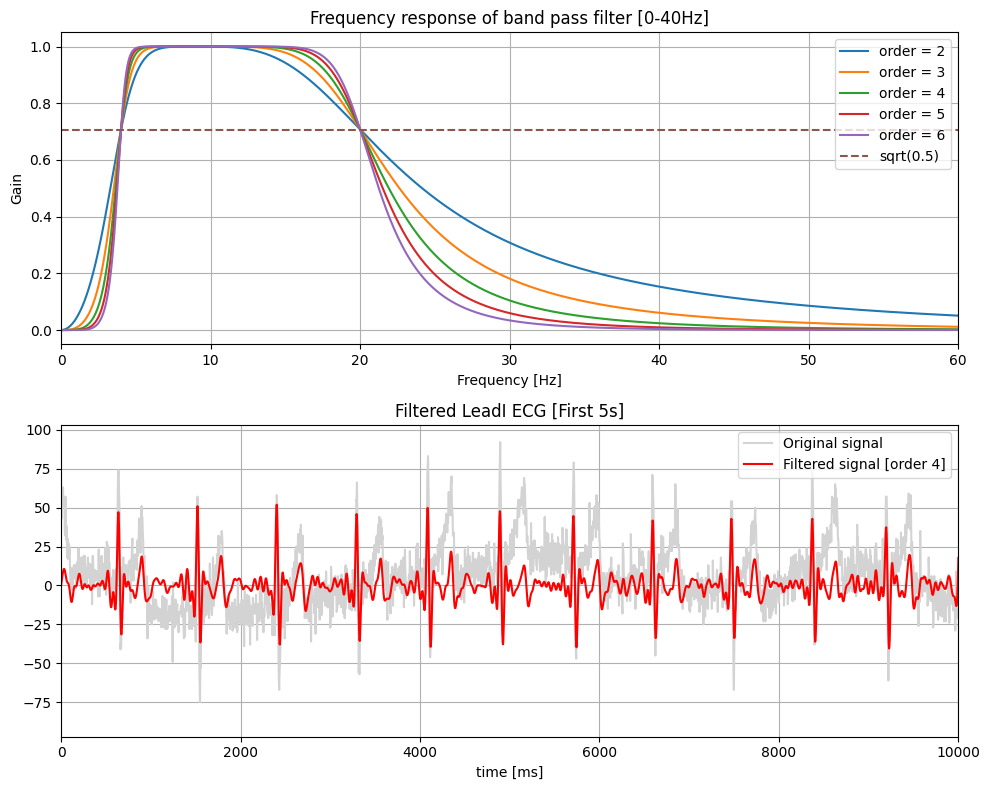

In [3]:

# Define bandpass filter functions
def butter_bandpass(lowcut, highcut,fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order,[low,high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = signal.filtfilt(b, a, data)
    return y

# Define low pass filter functions
def butter_lowpass(lowcut,fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order,low, btype='low')
    return b, a

def butter_lowpass_filter(data, lowcut, fs, order):
    b, a = butter_lowpass(lowcut, fs, order)
    y = signal.filtfilt(b, a, data)
    return y

# Filter implementation

# Parameters
lowcut = 4 #[Hz]
highcut = 20
fs = ECG_freq

# Plot the frequency response for a few different orders.
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10, 8), sharex=False)

for order in [2,3,4,5,6]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    ax[0].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" %order)

ax[0].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],'--', label='sqrt(0.5)')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_xlim(0,60)
ax[0].set_ylabel('Gain')
ax[0].grid(True)
ax[0].set_title('Frequency response of band pass filter [0-40Hz]') 
ax[0].legend(loc='upper right')

# Choose filter order
order = 4
# Apply the low pass filer to the lead I ECG filter
filtered_lead1_ecg_p1 = butter_bandpass_filter(lead1_ecg_p1,lowcut, highcut, fs, order)

# Get time 
t = np.array(raw_ECG_p1[:,0]) - raw_ECG_p1[0,0] #[ms]

# Plot the first 5s of the filtered signal in time domain
ax[1].plot(t,lead1_ecg_p1, label='Original signal', color='lightgray')
ax[1].plot(t,filtered_lead1_ecg_p1, label='Filtered signal [order %d]' %order, color= 'red')
ax[1].set_xlabel('time [ms]')
ax[1].set_xlim(0,10000)
ax[1].grid(True)
ax[1].set_title('Filtered LeadI ECG [First 5s]') 
ax[1].legend(loc='upper right')
plt.tight_layout()
plt.show()


#### c) Artifact detection 

We are looking for the percentage of recorded ECG data that contains artifacts over the complete dataset (last 50 s for each clip). This can be computed by taking the ratio between the sum of the flagged intervals and the accumulated time of the ECG recordings.

The values of the ECG signal that were found to have artifacts have been replaced by linear interpolation of the values at the extreme of each artifact.

We noticed the artifact detector could miss artifacts at the extremes of the RRI arrays. We single out the remaining artifacts using an adaptive threshold around the mean of RRI values in a sliding window, and replace them with the mean RR interval value.

References: 

Processing ECG data ...
Finished processing ECG data

Percentage of ECG data having defects: 6.59 %



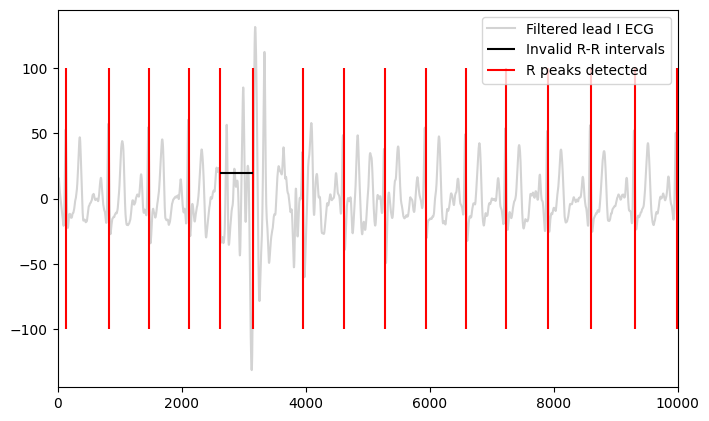

In [37]:

# Utility functions for artifact detection algorithm

def get_RRI(filtered_ecg_signal, fs):
    '''
    Returns an array containing the RR peak intervals for a signal, in ms. 
    '''
    # #Compute the derivative of the filtered signal
    diff = np.diff(filtered_ecg_signal) 

    # # Compute the square of the derivative to evidence the peaks in the signal
    squared = diff*diff

    # Use scipy find RR peaks (hand tuned)
    peaks, _ = signal.find_peaks(squared, height= 20, threshold= None, distance=120, prominence= 10)
    RRI = np.diff(peaks)
    RRI_ms = RRI*1000/fs
    
    return RRI_ms, peaks

def get_CBD(RRI):
    '''
    Return the Criterion Beat Difference given an array of RR peaks intervals. Based on the work of Hovsepian et al. 
    '''
    # Make sure RRI interval is not all empty
    if RRI.size ==0:
        Q1 = np.NaN
        Q2 = np.NaN
        Q3 = np.NaN

    else:
        Q1 = np.nanpercentile(RRI, 25)
        Q2 = np.nanpercentile(RRI, 50)
        Q3 = np.nanpercentile(RRI, 75)

    QD = (Q3-Q1)/2.0 # Quartile Deviation
    MAD = (Q2-2.9*QD)/3.0
    MED = 3.32*QD

    CBD =(MAD+MED)/2.0
    return CBD

def detect_artifacts(RRI, CBD):
    '''
    Detects artifacts in ECG signal. Input needs to be filtered ecg
    '''
    has_artifacts = False
    last_valid_RRI = 0

    valid_RRI_indices = np.ones((1,len(RRI))).reshape(-1,1)
    for i in range(1,len(RRI)-1):
        if RRI[i-1] >= 300 and RRI[i-1]<=2000:
            if abs(RRI[i]-RRI[i-1])<=CBD:
                valid_RRI_indices[i]=1
            else: 
                valid_RRI_indices[i]=0
        else:
            if abs(RRI[i]-last_valid_RRI)<=CBD:
                valid_RRI_indices[i]=1
            else:
                if abs(RRI[i]-RRI[i-1])<=CBD and abs(RRI[i]-RRI[i+1])<=CBD:
                    valid_RRI_indices[i]=1
                else:
                    valid_RRI_indices[i]=0
                    

    # Count artifacts
    n_artifacts = len(RRI)-np.sum(valid_RRI_indices)
    if n_artifacts > 0:
        has_artifacts = True
    return has_artifacts, valid_RRI_indices

def removeArtifacts(rri, artifact_indices):
    '''
    Remove artifacts in the RR interval array by linearly interpolating between valid beats. 
    '''

    groupedIndices = []
    groupStart = 0
    while groupStart < len(artifact_indices):
        groupCount = 1 
        groupEnd = groupStart + 1
        while groupEnd < len(artifact_indices) and artifact_indices[groupEnd] - artifact_indices[groupEnd-1] == 1:
            groupCount += 1
            groupEnd += 1
        groupedIndices.append((artifact_indices[groupStart], groupCount))
        groupStart = groupEnd

    for group in groupedIndices:
        firstWrongInd = group[0]
        lastWrongInd = group[0] + group[1] - 1
        startInter = rri[firstWrongInd-1]
        endInter = rri[lastWrongInd+1]
        interPoints = np.linspace(startInter, endInter, group[1]+2)

        for off, point in enumerate(interPoints[1:-1]):
            rri[firstWrongInd+off] = point
    return rri

def smoothRemainingArtifacts(rri):
    '''
    We noticed the artifact detector could miss artifacts at the extremes of the RRI arrays. 
    We single out the remaining artifacts using an adaptive threshold around the mean of RRI values in a sliding window, and replace them with the mean RR interval value.
    '''
    window_size = 9    # averaging over 9 inter beat inetervals, use a odd number as window_size
    numbers_series = pd.Series(rri)

    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()
    moving_averages_list = moving_averages.tolist()
    averages = moving_averages_list[window_size - 1:]

    for i in range(int((len(rri) - len(averages)) / 2)):   # make sure that window_size is an odd number !!!
        averages.insert(0, averages[0])
        averages.append(averages[-1])
    stdev = np.std(rri)
    upperThresh = averages + 1.25*stdev
    lowerThresh = averages - 1.25*stdev

    for index, val in enumerate(rri):
        if val < lowerThresh[index] or val > upperThresh[index]:
            rri[index] = averages[index]
    return rri

# Minimum length of the RR interval array for the clip to be considered valid
DEPRECATED_RRI_THRESH = 20

# Variables for percentage calculation
total_time = 0
total_artifact_time = 0

# Progress bar
pbar = tqdm(range(1455))

# Dict to store pre-processed data 
pre_processed_ecg_data = {}

keys = ['ID','clip','fs','RRI','ECG_spectral']
for k in keys:
    pre_processed_ecg_data[k]=[]

valence_self_ratings_data = {}
arousal_self_ratings_data = {}

print("Processing ECG data ...")

totCount = 0
# load ECG data
for i in range(44):
    if i<9:
        pn = "0"+str(i+1)
    else: 
        pn= str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)

        # Extract sampling frequency of ECG
        fs = participant_data["FS_ECG"]

        # Clips
        clip_ids=participant_data["recordings"].keys()
        # Extract ECG for each clip 
        for clip in clip_ids:
            # Get raw ECG
            raw_ECG= np.array(participant_data["recordings"][clip]["ECG"])

            valence_self_ratings_data[totCount] = np.array(participant_data["recordings"][clip]["valence"])
            arousal_self_ratings_data[totCount] = np.array(participant_data["recordings"][clip]["arousal"])
            totCount += 1

            # Get lead1 ECG signal
            lead1_ecg= np.array(raw_ECG[:,1]-raw_ECG[:,2])
            t = np.array(raw_ECG[:,0]) - raw_ECG[0,0] #[ms]

            # Filter ECG signal for time domain features
            filtered_lead1_ecg = butter_bandpass_filter(lead1_ecg,lowcut, highcut, fs, order)
            
            # Filter ECG signal for spectral density features: we need to keep the low and very low frequencies
            lead1_ecg_spectral =  butter_lowpass_filter(lead1_ecg, highcut, fs, order)

            # Truncate the signal to look at only the last 50s of the signal
            filtered_lead1_ecg_50s = filtered_lead1_ecg[-(50*fs):] 
            lead1_ecg_spectral_50s = lead1_ecg_spectral[-(50*fs):] 
            t = t[-(50*fs):]
            t = t-t[0]

            # Add the 50s to the total time
            total_time += 50*1000.0 #[ms]

            # Get RR peaks intervals
            RRI, peaks = get_RRI(filtered_lead1_ecg_50s, fs)

            if len(RRI) < DEPRECATED_RRI_THRESH:
                # The entire clip is counted as time with artifacts
                total_artifact_time += 50*1000.0 #[ms]

                # Return invalid RRI interval array
                RRI = np.nan*np.ones((1, 3)).flatten()
                
            else:

                # Get Criterion beat interval for artifact detection
                CBD = get_CBD(RRI)

                # Check for artifacts
                artifact, idx = detect_artifacts(RRI, CBD)

                if artifact == True:
                    # Find the total time of flagged intervals
                    artifact_indices = np.where(idx==0)[0]
                    artifacts_time = np.sum(RRI[artifact_indices])

                    # Add to the general flagged time counter
                    total_artifact_time += artifacts_time

                    # Overwrite artifacts by linearly interpolating between valid RR intervals
                    RRI = removeArtifacts(RRI, artifact_indices)

                    # Smooth out remaining artifacts
                    RRI = smoothRemainingArtifacts(RRI)

                    # plot the section with artifact(s) for a select clip
                    if i==6 and clip==13:
                        # other candidates: i = 5 , clip = 26
                        plt.plot(t,filtered_lead1_ecg_50s, label='Filtered lead I ECG', color='lightgrey', zorder=1)
                        for j in artifact_indices:
                            plt.hlines(20, peaks[j]*1000/fs, peaks[j-1]*1000/fs,color='black', label="Invalid R-R intervals", zorder = 3)
                        legend = False
                        for k in peaks:
                            if not(legend):
                                plt.vlines(k*1000/fs, -100, 100, color='r', label='R peaks detected', zorder=2)
                                legend = True
                            else: 
                                plt.vlines(k*1000/fs, -100, 100, color='r',zorder=2)
                        plt.legend()
                        plt.xlim(0, 10000)
                
                # Smooth out clips (even the ones where no artifacts were found)
                RRI = smoothRemainingArtifacts(RRI)

            pre_processed_ecg_data['ID'].append(i+1)
            pre_processed_ecg_data['clip'].append(clip)
            pre_processed_ecg_data['fs'].append(fs)
            pre_processed_ecg_data['RRI'].append(RRI)
            pre_processed_ecg_data['ECG_spectral'].append(lead1_ecg_spectral_50s)
            pbar.update(1)

print("Finished processing ECG data")
print()
percentage = 100*(total_artifact_time/total_time)
print("Percentage of ECG data having defects: {:.2f} %".format(percentage))
print()
plt.show()

#### d) Feature extraction

We computed all the requested features both in the time and frequency domain. On top of them we also added five additional features that were chosen after reading the paper: "An Overview of Heart Rate Variability Metrics and Norms" by F. Shaffer and J. P. Ginsberg, referenced as [2]. These are:

* root mean squared of successive differences of heartbeats (IBI rms): as [2] explains, this metric reflects the beat-to-beat variance in HR and is the primary time-domain measure used to estimate the changes reflected in HRV
* number of adjacent IBI that differ by more than 50 ms: might give a hint on how 'dynamic' the emotial reaction to each clip is, we think clips containig unexpected scenes to lead to a bigger variation of adjacent IBIs
* percentage of the number of adjacent IBI that differ by more than 50 ms: complementaty to the one above, it might indicate how long (in percentage) the strong emotional reactions lasted for each clip
* HR max - HR min: a bigger range of HR might indicate the presence of a climax in the scene (point of maximum tension), clips that are steady all the way will have a small HR range
* max HRV (absolute value): as the one above, it might characterize clips that lead to a strong emotional reaction

References: 

In [6]:
def statistical_measurements(signal):
    mean = np.mean(signal)
    stdev = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    
    total= len(signal)
    # Percentage of values 1 standard deviation above mean
    above_1sd = 100.0*len(signal[signal>(mean+stdev)])/total

    # Percentage of values 1 standard deviation above mean
    below_1sd = 100.0*len(signal[signal<(mean-stdev)])/total

    results = np.asarray([mean, stdev, skewness, kurt, above_1sd, below_1sd])
    return results

def extra_features(IBI, HR, HRV):
    
    # root mean squared of successive differences of heartbeats (IBI rms)
    IBI_rms = math.sqrt(np.mean(np.square(IBI)))

    # number of adjacent IBI that differ by more than 50 ms
    count = 0
    i = 0
    while i < len(IBI)-1:
        if abs(IBI[i+1] - IBI[i]) > 50:
            count += 1
            i += 1
            while i < len(IBI)-1 and abs(IBI[i+1] - IBI[i]) > 50:
                count += 1
                i += 1
        i += 1
    
    IBI_outMaxDiff = count
    
    # percentage of the number of adjacent IBI that differ by more than 50 ms
    IBI_percOutMaxDiff = IBI_outMaxDiff / len(IBI)

    # Heart rate range
    # HR max - HR min
    HR_range = np.max(HR) - np.min(HR)

    # max HRV (absolute value)
    HRV_max = np.max(np.abs(HRV))

    results = np.asarray([IBI_rms, IBI_outMaxDiff, IBI_percOutMaxDiff, HR_range, HRV_max])
    return results

# Progress bar
pbar = tqdm(range(1455))

# Store statistics
n_features = 37 # 10 + 4 + 6 + 6 + 6 + 5

# Array shape: Participant_ID, Clip, features
ECG_features = np.zeros((0,2+n_features))
ECG_features_names = ['LF_PSD1', 'LF_PSD2', 'LF_PSD3', 'LF_PSD4', 'LF_PSD5', 'LF_PSD6', 'LF_PSD7', 'LF_PSD8', 'LF_PSD9', 'LF_PSD10', 
                    'VLF_PSD1', 'VLF_PSD2', 'VLF_PSD3', 'VLF_PSD4',
                    'IBI_mean', 'IBI_stdev', 'IBI_skew', 'IBI_kurt', 'IBI_sd+', 'IBI_sd-',
                    'HR_mean', 'HR_stdev', 'HR_skew', 'HR_kurt', 'HR_sd+', 'HR_sd-',
                    'HRV_mean', 'HRV_stdev', 'HRV_skew', 'HRV_kurt', 'HRV_sd+', 'HRV_sd-',
                    'IBI_rms', 'IBI_outMaxDiff', 'IBI_percOutMaxDiff', 'HR_range', 'HRV_max']

print("Extracting ECG features ...")

# Load pre_processed ECG data
for i in range(len(pre_processed_ecg_data['ID'])):
    # Define feature vector
    feature_vector = np.zeros((1, 2+n_features))

    feature_vector[0,0]=pre_processed_ecg_data['ID'][i] # Participant number
    feature_vector[0,1]=pre_processed_ecg_data['clip'][i] # clip number

    fs = pre_processed_ecg_data['fs'][i]

    # Filtered ECG for spectral features extraction
    ecg_spectral_features = pre_processed_ecg_data['ECG_spectral'][i]

    # Uncomment below to normalize
    # ecg_spectral_features = (ecg_spectral_features - np.mean(ecg_spectral_features))/(np.std(ecg_spectral_features))

    # 01: ten low frequency ([0–2.4] Hz) power spectral densities
    fr, Pxx_den = signal.welch(x=ecg_spectral_features, fs= fs, nperseg = 15*fs, noverlap= 10*fs, scaling='density', average='mean')

    # W1: [0,0.24Hz)
    feature_vector[0,2] = np.mean(Pxx_den[np.logical_and(fr>=0,fr<0.24)])
    
    # W2: [0.24,0.48Hz)
    feature_vector[0,3] = np.mean(Pxx_den[np.logical_and(fr>=0.24,fr<0.48)])

    # W3: [0.48,0.72Hz)
    feature_vector[0,4]= np.mean(Pxx_den[np.logical_and(fr>=0.48,fr<0.72)])

    # W4: [0.72,0.96Hz)
    feature_vector[0,5]= np.mean(Pxx_den[np.logical_and(fr>=0.72,fr<0.96)])

    # W5: [0.96,1.2Hz)
    feature_vector[0,6] = np.mean(Pxx_den[np.logical_and(fr>=0.96,fr<1.2)])

    # W6: [1.2,1.44Hz)
    feature_vector[0,7]= np.mean(Pxx_den[np.logical_and(fr>=1.2,fr<1.44)])
    
    # W7: [1.44,1.68Hz)
    feature_vector[0,8] = np.mean(Pxx_den[np.logical_and(fr>=1.44,fr<1.68)])
    
    # W8: [1.68,1.92Hz)
    feature_vector[0,9] = np.mean(Pxx_den[np.logical_and(fr>=1.68,fr<1.92)])
    
    # W9: [1.92,2.16Hz)
    feature_vector[0,10] = np.mean(Pxx_den[np.logical_and(fr>=1.92,fr<2.16)])
    
    # W10:[2.16,2.4Hz)
    feature_vector[0,11] = np.mean(Pxx_den[np.logical_and(fr>=2.16,fr<2.4)])

    # 02: four very slow response ([0–0.04] Hz) PSDs
    # W1: [0,0.01Hz) window
    feature_vector[0,12] = np.mean(Pxx_den[np.logical_and(fr>=0,fr<0.01)])
    
    # W2: [0.01,0.02Hz) window
    feature_vector[0,13] = np.mean(Pxx_den[np.logical_and(fr>=0.01,fr<0.02)])
    
    # W3: [0.02,0.03Hz) window
    feature_vector[0,14] = np.mean(Pxx_den[np.logical_and(fr>=0.02,fr<0.03)])

    # W4: [0.03,0.04Hz] window
    feature_vector[0,15] = np.mean(Pxx_den[np.logical_and(fr>=0.03 , fr<=0.04)])

    # Inter Beat Intervals (aka RR Intervals)
    IBI = pre_processed_ecg_data['RRI'][i]

    if np.sum(np.isnan(IBI).astype(int)) > 0:
        # Clip has deprecated measurements, replace all remaining features with nan
        feature_vector[0, 16:34] = np.nan*np.ones((1, 18)).flatten()
        
        # Alternative: replace all features with nan, even spectral features
        # feature_vector[0,2:34] = np.nan*np.ones((1,n_features)).flatten()
    else:     
        # Heart rate: moving average of (1/IBI) with a window size of 5
        beat_rate= pd.Series(1.0/IBI)
        HR = beat_rate.rolling(5).mean()
        
        # Heart rate variability
        HRV = np.diff(IBI)

        # 03: statistical measurements over inter beat intervals
        feature_vector[0,16:22] = statistical_measurements(IBI)

        # 04: statistical measurements over heart rate
        feature_vector[0,22:28] = statistical_measurements(HR)

        # 04: statistical measurements over heart rate variability
        feature_vector[0,28:34] = statistical_measurements(HRV)
    
    # Stack feature vector in data matrix
    ECG_features = np.vstack((ECG_features, feature_vector))
    pbar.update(1)

print("Finished extracting ECG features")
print()



Extracting ECG features ...
Finished extracting ECG features



### 1.2 EMO


In [7]:
# Progress bar
pbar = tqdm(range(1455))

# Store statistics
n_features = 72 # 6*12

# Array shape: Participant_ID, Clip, features
EMO_features = np.zeros((0,2+n_features))
EMO_features_names=np.array(['V_def_UL_mean', 'V_def_UL_stdev', 'V_def_UL_skew','V_def_UL_kurt', 'V_def_UL_sd+', 'V_def_UL_sd-', 
                    'V_def_LL_mean', 'V_def_LL_stdev', 'V_def_LL_skew','V_def_LL_kurt', 'V_def_LL_sd+', 'V_def_LL_sd-',
                    'H_def_LLC_mean', 'H_def_LLC_stdev', 'H_def_LLC_skew','H_def_LLC_kurt', 'H_def_LLC_sd+', 'H_def_LLC_sd-', 
                    'V_def_LLC_mean', 'V_def_LLC_stdev', 'V_def_LLC_skew','V_def_LLC_kurt', 'V_def_LLC_sd+', 'V_def_LLC_sd-', 
                    'H_def_RLC_mean', 'H_def_RLC_stdev', 'H_def_RLC_skew','H_def_RLC_kurt', 'H_def_RLC_sd+', 'H_def_RLC_sd-',
                    'V_def_RLC_mean', 'V_def_RLC_stdev', 'V_def_RLC_skew','V_def_RLC_kurt', 'V_def_RLC_sd+', 'V_def_RLC_sd-',
                    'def_RE_mean', 'def_RE_stdev', 'def_RE_skew','def_RE_kurt', 'def_RE_sd+', 'def_RE_sd-',
                    'def_LE_mean', 'def_LE_stdev', 'def_LE_skew','def_LE_kurt', 'def_LE_sd+', 'def_LE_sd-',
                    'def_RC_mean', 'def_RC_stdev', 'def_RC_skew','def_RC_kurt', 'def_RC_sd+', 'def_RC_sd-',
                    'def_LC_mean', 'def_LC_stdev', 'def_LC_skew','def_LC_kurt', 'def_LC_sd+', 'def_LC_sd-',
                    'def_RLid_mean', 'def_RLid_stdev', 'def_RLid_skew','def_RLid_kurt', 'def_RLid_sd+', 'def_RLid_sd-',
                    'def_LLid_mean', 'def_LLid_stdev', 'def_LLid_skew','def_LLid_kurt', 'def_LLid_sd+', 'def_LLid_sd-'])

print("Extracting EMO features ...")
# Load EMO data
for i in range(44):
    if i<9:
        pn = "0"+str(i+1)
    else: 
        pn= str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)

        # Extract sampling frequency of EMO
        fs = participant_data["FS_EMO"]

        # Clips
        clip_ids=participant_data["recordings"].keys()
        # Extract EMO for each clip 
        for clip in clip_ids:
            # Define feature vector
            feature_vector = np.zeros((1, 2+n_features))
            
            feature_vector[0,0]=i+1 # Participant number
            feature_vector[0,1]=clip # clip number

            # Raw EMO data
            raw_EMO = np.array(participant_data["recordings"][clip]["EMO"]) 

            # Truncate the signal to look at only the last 50s
            EMO_50s= raw_EMO[-(50*fs):] 

            # Extract statistical measurements

            # 01: Vertical deformation of Upper lip
            feature_vector[0,2:8] = statistical_measurements(EMO_50s[:,1])
            
            # 02: Vertical deformation of Lower Lip
            feature_vector[0,8:14] = statistical_measurements(EMO_50s[:,2])

            # 03: Horizontal deformation of Left Lip corner
            feature_vector[0,14:20] = statistical_measurements(EMO_50s[:,3])

            # 04: Veritcal deformation of Left Lip corner
            feature_vector[0,20:26] = statistical_measurements(EMO_50s[:,4])

            # 05: Horizontal deformation of Right Lip corner
            feature_vector[0,26:32] = statistical_measurements(EMO_50s[:,5])

            # 06: Veritcal deformation of Right Lip corner
            feature_vector[0,32:38] = statistical_measurements(EMO_50s[:,6])

            # 07: Deformation of the Right Eyebrow
            feature_vector[0,38:44] = statistical_measurements(EMO_50s[:,7])
            
            # 08: Deformation of the Left Eyebrow
            feature_vector[0,44:50] = statistical_measurements(EMO_50s[:,8])

            # 09: Deformation of the Right Cheek
            feature_vector[0,50:56] = statistical_measurements(EMO_50s[:,9])

            # 10: Deformation of the Left Cheek
            feature_vector[0,56:62] = statistical_measurements(EMO_50s[:,10])

            # 11: Deformation of the Right Lid
            feature_vector[0,62:68] = statistical_measurements(EMO_50s[:,11])

            # 12: Deformation of the Left Lid
            feature_vector[0,68:74] = statistical_measurements(EMO_50s[:,12])

            # Stack feature vector in data matrix
            EMO_features = np.vstack((EMO_features, feature_vector))
            pbar.update(1)

print("Finished extracting EMO features")
print()

Extracting EMO features ...
Finished extracting EMO features



### 1.3 EDA

#### a) Power Spectral Distribution
We obtain the PSD of the GSR signal with the same method used above for the ECG signal, keeping the same parameters for the Welch implementation. 

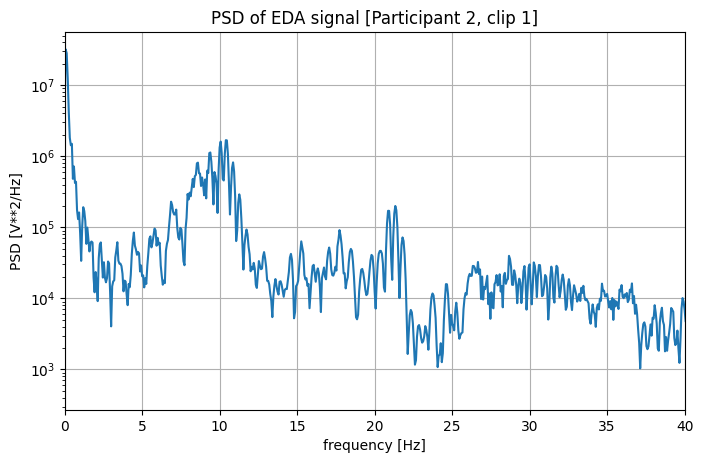

In [8]:
# we want the power spectral desity of the EDA signal of the second participant watching clip 1
with open("ex2_recordings/participant_02.pkl", "rb") as f:
    participant_02_data = pickle.load(f)

#Extract EDA data
GSR_freq = participant_02_data["FS_GSR"]
raw_GSR= np.array(participant_02_data["recordings"][1]["GSR"][:,1])

t = participant_02_data["recordings"][1]["GSR"][:,0]
t = t - t[0]

# Parameters for calculating the PSD 
# From [1] in exercise handout: Welch method using window length of 15xsr overlap 10xsr where sr denotes sampling rate
f, Pxx_den = signal.welch(x=raw_GSR, fs= GSR_freq, nperseg = 15*GSR_freq, noverlap= 10*GSR_freq, scaling='density', average='mean')

plt.semilogy(f, Pxx_den)
plt.xlim(0,40)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('PSD of EDA signal [Participant 2, clip 1]')
plt.grid(True)
plt.show()

#### b) Filtering
THe power spectrum indicates that the most significant part of the signal is concentrated in the low frequencies which is expected from what is known of the GSR signal. GSR is a slow signal with a tonic component [0-0.16Hz] and a phasic component [0.16-2.4Hz] as mentioned in [2]. We cna therefore use a low pass filter at 2.4Hz cutoff to retain only the useful part of the GSR signal. 

A simple low pass filter however does not eliminate very fast and high amplitude artifacts that can be noticed in the raw GSR plots of some participants. Therefore we add a prefiltering step on teh signal derivative. After applyinf  25Hz low pass filter to the derivative, replacing all derivative values above or below a threshold by a random variable sampled from a truncated normal dristibution mirroring the inherent noise of the derivative signal. The values fo teh thresholds and low pass filter cutoff were determined empirically. (find source?)

Sources: 


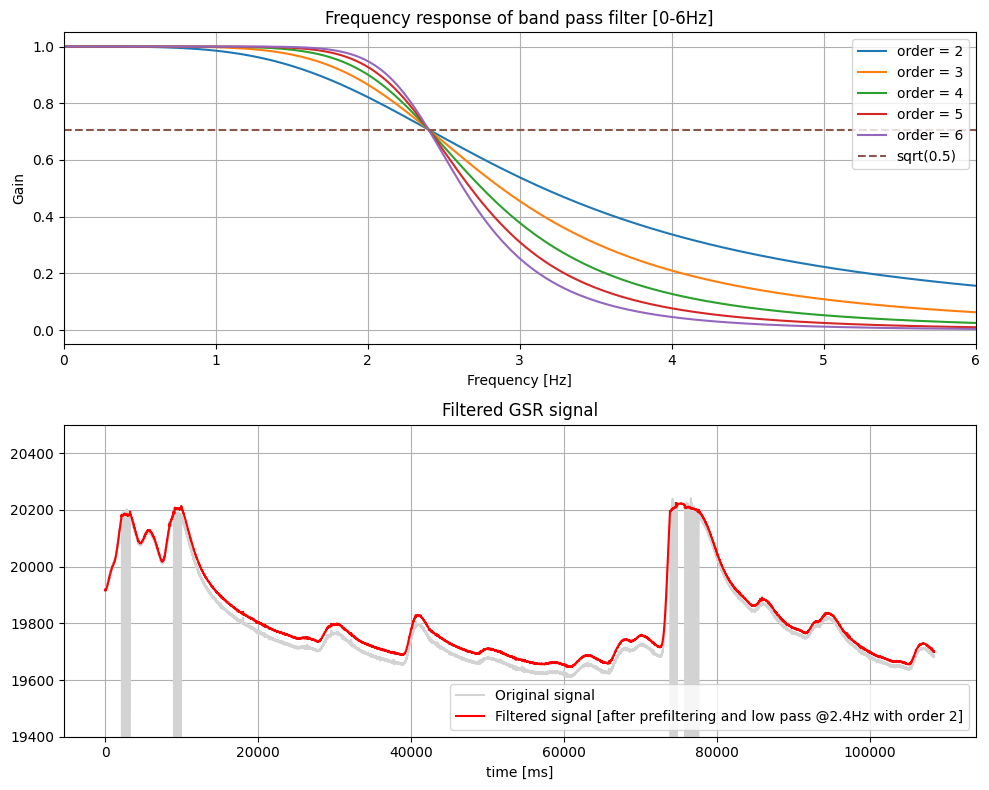

In [9]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    '''
    Function to simplify the application of truncnorm
    '''
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# Prefiltering 
def prefilter_gsr(raw_gsr, threshold):
    '''
    GSR prefiltering step on the signal derivative
    '''
    # Threshold the signal derivative
    derivative = np.diff(raw_gsr)
    filtered_derivative = derivative

    # Smoothe derivative using a low pass filter at 25Hz
    filtered_derivative = butter_lowpass_filter(filtered_derivative,25, GSR_freq, order)

    # Replace sections that are above the threshold by a random variable from a truncated normal distribution
    N = get_truncated_normal(mean = 0, sd = 0.5,low= -1 , upp = 1)
    mask1 = filtered_derivative>threshold
    mask2= filtered_derivative<-threshold
    mask = mask1+mask2
    c = np.count_nonzero(mask)
    fillers = N.rvs(c)
    filtered_derivative[mask]= fillers
    
    # reconstruct the pre-filtered GSR signal
    prefiltered_GSR = np.concatenate(([raw_gsr[0]], filtered_derivative)).cumsum()
    
    return prefiltered_GSR 

# Low pass filter implementation
# Parameters
lowcut = 2.4
fs = GSR_freq

# Plot the frequency response for a few different orders.
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10, 8), sharex=False)

for order in [2,3,4,5,6]:
    b, a = butter_lowpass(lowcut, fs, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    ax[0].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" %order)

ax[0].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],'--', label='sqrt(0.5)')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_xlim(0,6)
ax[0].set_ylabel('Gain')
ax[0].grid(True)
ax[0].set_title('Frequency response of band pass filter [0-6Hz]') 
ax[0].legend(loc='upper right')

# Choose filter order
order = 2
prefilter_threshold= 20

# Apply prefilter
prefiltered_gsr = prefilter_gsr(raw_GSR, prefilter_threshold)

# Apply low pass filer 
filtered_gsr = butter_lowpass_filter(prefiltered_gsr,lowcut, fs, order)

# Plot the first 5s of the filtered signal in time domain
ax[1].plot(t, raw_GSR, label='Original signal', color='lightgrey')
# ax[1].plot(prefiltered_gsr, label='Prefiltered signal')
ax[1].plot(t, prefiltered_gsr, label='Filtered signal [after prefiltering and low pass @2.4Hz with order %d]' %order, color = 'red')
ax[1].set_xlabel('time [ms]')
ax[1].set_ylim(19400, 20500)
ax[1].grid(True)
ax[1].set_title('Filtered GSR signal') 
ax[1].legend(loc='lower right')
plt.tight_layout()
plt.show()

#### c-d) Feature extraction

Base features; base features were extracted following the methods indicated in the ASCERTAIN, DECAF ans DEAP database papers (TODO: cite them)

Additional features:
From additional reading we know the GSR signal can be further decomposed into two components:
* A very low frequency tonic component that represents the slow shifts in a person's base skin conductance levels, usually due to factors such as external temperature, humidity or build up of sweat etc. 
* A phasic component that reflects more abrupt changes in skin conductance in nresponse to emotions (sympathetic nervous system)
As suggested in litterature [], we can extract features from the phaisc component of the signal directly 

Commonly extracted features in litterature include:
* The average amplitude of the SCR peak in the phasic signal (peak height - onset height) : shows the amplitude of the emotional response
* The average rise time of an SCR peak in the phasic signal: speed of the response
* The half recovery time of the SCR: gives an idea of the recovery rate 
* Area under hte curve for phasic componenent
* The mean of the tonic component: undestanding of the base skin response

> Warning: cvxEDA for separation of phasic and tonic components is slow. This cell takes ~ 15min to run


In [10]:
import neurokit2 as nk

pbar = tqdm(range(1455))

# Store statistics
n_features = 32 # 15 + 3 (feature 9) + 9 (feature 15) + 5 additional features

# Array shape: Participant_ID, Clip, features
EDA_features = np.zeros((0,2+n_features))

EDA_features_names = np.array(['mean_res', 'mean_d_res', 'mean_abs_d_res', 'mean_neg_d_res', '%_neg_d_res', 'stdev_res', '#_min_cond', 
                    'avg_rise_t_GSR', 'PSD1', 'PSD2', 'PSD3','PSD4', 'stdev_cond', 'mean_d_cond', 'mean_abs_d_cond', 'mean_abs_d2_cond', 
                    '#_min_res', 'log_psd_1','log_psd_2','log_psd_3','log_psd_4','log_psd_5','log_psd_6','log_psd_7','log_psd_8','log_psd_9',
                    'log_psd_10', 'phasic_peak_amp', 'phasic_rise_time', 'phasic_recovery_time','phasic_auc', 'mean_tonic'])

# Filter parameters
order = 2
prefilter_threshold= 20

print("Extracting EDA features ...")

# Load EDA data
for i in range(44):
    if i<9:
        pn = "0"+str(i+1)
    else: 
        pn= str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)

        # Extract sampling frequency of EDA
        fs = participant_data["FS_GSR"]

        # Clips
        clip_ids=participant_data["recordings"].keys()
        # Extract EDA for each clip 
        for clip in clip_ids:
            feature_vector = np.zeros((1, 2+n_features))
            
            feature_vector[0,0]=i+1 # Participant number
            feature_vector[0,1]=clip # clip number

            raw_gsr= np.array(participant_data["recordings"][clip]["GSR"][:,1])

            t = participant_data["recordings"][clip]["GSR"][:,0]
            t = t - t[0]
            
            # Apply prefilter
            prefiltered_gsr = prefilter_gsr(raw_gsr, prefilter_threshold)

            # Apply low pass filter 
            filtered_gsr = butter_lowpass_filter(prefiltered_gsr,lowcut, fs, order)

            # Truncate the signal to look at only the last 50s of the signal
            filtered_gsr_50s= filtered_gsr[-(50*fs):] 
            t = t[-(50*fs):]
            t = t-t[0]

            first_derivative = np.diff(filtered_gsr_50s)

            # 01: mean skin resistance
            feature_vector[0,2] = np.mean(filtered_gsr_50s)
            
            # 02: mean of first derivatives of skin resistance
            feature_vector[0,3] = np.mean(first_derivative)
            
            # 03: mean of absolute values of first derivatives of skin resistance
            feature_vector[0,4] = np.mean(np.abs(first_derivative))
            
            # 04: mean first derivative for negative values only
            feature_vector[0,5] = np.mean(first_derivative[first_derivative<0])

            # 05: percentage of time with negative first derivative
            feature_vector[0,6] = 100.0*(len(first_derivative[first_derivative<0])/len(first_derivative))
            
            # 06: standard deviation of skin resistance
            feature_vector[0,7] = np.std(filtered_gsr_50s)

            # 07: number of local minima in the skin conductance signal
            skin_cond = 1/filtered_gsr_50s
            feature_vector[0,8] = len(signal.argrelmin(skin_cond, order = 100)[0])

            # 08: average rising time of the GSR signal > time the derivative is positive
            feature_vector[0,9] = len(first_derivative[first_derivative>0])/fs
            
            # 09: power density estimates; 4 sub-bands in the [0-0.4] Hz band
            fr, Pxx_den = signal.welch(x=filtered_gsr_50s, fs= fs, nperseg = 15*fs, noverlap= 10*fs, scaling='density', average='mean')
            
            # W1: [0,0.1Hz) window
            feature_vector[0,10] = np.mean(Pxx_den[np.logical_and(fr>=0,fr<0.1)])
            
            # W2: [0.1,0.2Hz) window
            feature_vector[0,11] = np.mean(Pxx_den[np.logical_and(fr>=0.1,fr<0.2)])
            
            # W3: [0.2,0.3Hz) window
            feature_vector[0,12] = np.mean(Pxx_den[np.logical_and(fr>=0.2,fr<0.3)])

            # W4: [0.3,0.4Hz] window
            feature_vector[0,13] = np.mean(Pxx_den[np.logical_and(fr>=0.3 , fr<=0.4)])
            
            # 10: standard deviation of skin conductance
            feature_vector[0,14] = np.std(skin_cond)
            
            # 11: mean of first derivatives of skin conductance
            d_skin_cond = np.diff(skin_cond)
            feature_vector[0,15] = np.std(d_skin_cond)

            # 12: mean of absolute values of first derivatives of skin conductance
            feature_vector[0,16] = np.mean(np.abs(d_skin_cond))
            
            # 13: mean of absolute values of second derivatives of skin conductance
            feature_vector[0,17] = np.mean(np.abs(np.diff(d_skin_cond)))
            
            # 14: number of local minima in the skin resistance signal
            feature_vector[0,18] = len(signal.argrelmin(filtered_gsr_50s, order = 100)[0])

            # 15: log power density estimates; 10 sub-bands in the [0-2.4] Hz band
            log_psd = np.log(Pxx_den)
            # W1: [0,0.24Hz)
            feature_vector[0,19] = np.mean(log_psd[np.logical_and(fr>=0,fr<0.24)])
            
            # W2: [0.24,0.48Hz)
            feature_vector[0,20] = np.mean(log_psd[np.logical_and(fr>=0.24,fr<0.48)])

            # W3: [0.48,0.72Hz)
            feature_vector[0,21]= np.mean(log_psd[np.logical_and(fr>=0.48,fr<0.72)])

            # W4: [0.72,0.96Hz)
            feature_vector[0,22]= np.mean(log_psd[np.logical_and(fr>=0.72,fr<0.96)])

            # W5: [0.96,1.2Hz)
            feature_vector[0,23] = np.mean(log_psd[np.logical_and(fr>=0.96,fr<1.2)])

            # W6: [1.2,1.44Hz)
            feature_vector[0,24]= np.mean(log_psd[np.logical_and(fr>=1.2,fr<1.44)])
            
            # W7: [1.44,1.68Hz)
            feature_vector[0,25] = np.mean(log_psd[np.logical_and(fr>=1.44,fr<1.68)])
            
            # W8: [1.68,1.92Hz)
            feature_vector[0,26] = np.mean(log_psd[np.logical_and(fr>=1.68,fr<1.92)])
            
            # W9: [1.92,2.16Hz)
            feature_vector[0,27] = np.mean(log_psd[np.logical_and(fr>=1.92,fr<2.16)])
            
            # W10:[2.16,2.4Hz)
            feature_vector[0,28] = np.mean(log_psd[np.logical_and(fr>=2.16,fr<2.4)])

            # Additional features
            # Normalise the signal: 
            filt_gsr_norm = (filtered_gsr_50s - filtered_gsr_50s.mean()) / filtered_gsr_50s.std()
            
            # Decompose the signal in phasic and tonic components - cvxEDA method from Neurokit 2 library
            signals= eda_phasic(filt_gsr_norm, sampling_rate=fs, method="cvxeda")
            phasic = signals['EDA_Phasic'].values
            tonic = signals['EDA_Tonic'].values

            # Get phasic component features using standard neurokit 2 library algorithm
            _, features = eda_peaks(phasic,sampling_rate=fs,  method="neurokit", amplitude_min=0.05)

            # Additional feature 1: average peak amplitude (= peak heigh - onset height)
            amplitude = features["SCR_Amplitude"]
            amplitude = amplitude[amplitude>0.1] # amplitude too small means the algorithm misdetected something
            
            if amplitude.size ==0: # if the amplitude array is empty
                feature_vector[0,29] = 0
            else : 
                feature_vector[0,29] = np.mean(amplitude)

            # Additional feature 2: average rise time (time between onset and peak)
            rise_time = features["SCR_RiseTime"]
            rise_time = rise_time[rise_time>0.5] # rising too fast means the detected peaks might be wrong
            
            if rise_time.size ==0: # if the rise_time array is empty
                feature_vector[0,30] = 0
            else : 
                feature_vector[0,30] = np.mean(rise_time)

            # Additional feature 3: average recovery time (time of decay from peak to 1/2 amplitude)
            
            recovery_time = features["SCR_RecoveryTime"]
            recovery_time = recovery_time[recovery_time>0.5]

            if recovery_time.size ==0: # if the amplitude array is empty
                feature_vector[0,31] = 0
            else : 
                feature_vector[0,31] = np.mean(recovery_time)

            # Additional feature 4: Area under the curve
            AUC_phasic = np.sum(phasic*(1/fs))
            feature_vector[0,32] = AUC_phasic

            # Additional feature 5: mean tonic signal 
            feature_vector[0,33] = np.mean(tonic)

            # Stack feature vector in data matrix
            EDA_features = np.vstack((EDA_features, feature_vector))
            pbar.update(1)
            
print("Finished extracting EDA features")
print()

Extracting EDA features ...
Finished extracting EDA features



### 1.4 Valence and arousal
#### a) Pearson correlation coefficient
We use scipy.stats implementation of the pearson correlation coefficient

In [11]:
# We need to calculate the Pearson correlaECG_features_namestion coefficient between valence and arousal for all participants and clips in the dataset
valence= np.zeros((0,1))
arousal= np.zeros((0,1))

for i in range(44):
    if i<9:
        pn = "0"+str(i+1)
    else: 
        pn= str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)
        # Clips
        clip_ids=participant_data["recordings"].keys()
        # Extract ECG for each clip 
        for clip in clip_ids:
            v = np.array(participant_data["recordings"][clip]["valence"]).reshape(1,-1)
            a = np.array(participant_data["recordings"][clip]["arousal"]).reshape(1,-1)

            valence = np.vstack((valence, v))
            arousal = np.vstack((arousal, a))

pearson_coeff, p_val=pearsonr(np.concatenate(valence),np.concatenate(arousal))
print("The pearson correlation coefficient between valence and arousal:{:.4f}".format(pearson_coeff))


The pearson correlation coefficient between valence and arousal:-0.0177


**Interpretation:**
 
The pearson coefficient is very close to the zero, which means there is no linear correlation between sel reported valence and arousal. That means the valence and arousal ratings can be used as wo separate dimensions to evaluate the emotional state of the participant. 

#### b) Distribution

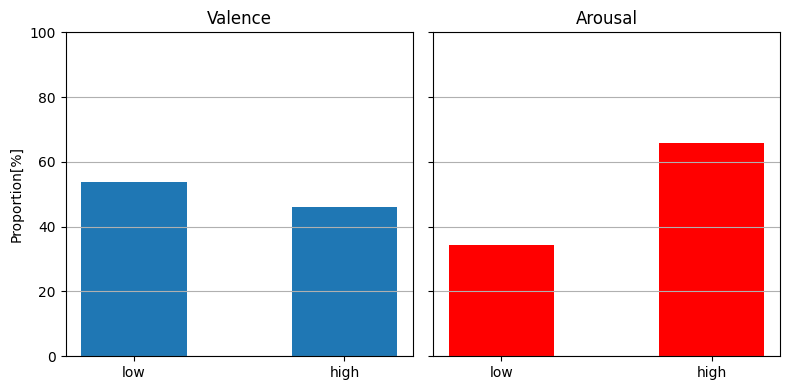

In [12]:

valence_dist = (valence>0).astype(int)
arousal_dist = (arousal>3).astype(int)

v_class, v_counts = np.unique(valence_dist, return_counts=True)
a_class, a_counts = np.unique(arousal_dist, return_counts=True)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8, 4), sharey=True)

ax[0].bar(v_class, 100*v_counts/np.sum(v_counts), 0.5, tick_label=['low','high'])
ax[0].set_ylim(0,100)
ax[0].set_title('Valence')
ax[0].set_ylabel('Proportion[%]')
ax[0].grid(axis='y')
ax[1].bar(a_class,100*a_counts/np.sum(a_counts),0.5, tick_label=['low','high'],color='red')
ax[1].set_title('Arousal')
ax[1].grid(axis='y')
plt.tight_layout()

plt.show()

**Discussion:**
 
The class distribution plot shows that while the Valence dataset seems roughly balanced between ```high``` and ```low``` instances, the Arousal dataset is imbalanced, with ```high``` Arousal recordings being more represented than low Arousal ones. This might need to be taken into account when training the Classifier. 


## 2. Classification 

### Random Forest Classifier

#### a) Data loading and preprocessing
In a first step we look into the feature data and make it can be used to train the classifier: it doesn't contain any ```nan``` or ```inf``` values 
* ECG data:
* EMO data:
* EDA data: potential issues are tackled directly in the feature extraction section  
* EEG data: we test different imputation strategies: mean, median, zero and choose the one leading to the best results in classification

In [15]:
# Data imputation functions
def impute_mean(data):
    for feature in data.T: # check column by column:
        feature = np.nan_to_num(x=feature,copy=False, nan=np.mean(feature[np.isfinite(feature)]), posinf = np.mean(feature[np.isfinite(feature)]), neginf = np.mean(feature[np.isfinite(feature)]))
    return data

def impute_median(data):
    for feature in data.T: # check column by column:
        feature = np.nan_to_num(x=feature,copy=False, nan=np.median(feature[np.isfinite(feature)]), posinf = np.median(feature[np.isfinite(feature)]), neginf = np.median(feature[np.isfinite(feature)]))
    return data

def impute_zero(data):
    for feature in data.T: # check column by column:
        feature = np.nan_to_num(x=feature,copy=False, nan=0, posinf = 0, neginf=0)
    return data

# Load features
n_eeg_features = 88
EEG_features = np.zeros((0, 2 + n_eeg_features))

EEG_features_names= np.array(
                    ['CH1_mean', 'CH1_stdev', 'CH1_skew','CH1_kurt', 'CH1_sd+', 'CH1_sd-','CH1_d_mean', 'CH1_prop_d_neg', 'CH1_mean_#_peaks', 'CH1_d_inv_mean','CH1_inv_mean_#_peaks',
                    'CH2_mean', 'CH2_stdev', 'CH2_skew','CH2_kurt', 'CH2_sd+', 'CH2_sd-','CH2_d_mean', 'CH2_prop_d_neg', 'CH2_mean_#_peaks', 'CH2_d_inv_mean','CH2_inv_mean_#_peaks',
                    'CH3_mean', 'CH3_stdev', 'CH3_skew','CH3_kurt', 'CH3_sd+', 'CH3_sd-','CH3_d_mean', 'CH3_prop_d_neg', 'CH3_mean_#_peaks', 'CH3_d_inv_mean','CH3_inv_mean_#_peaks',
                    'CH4_mean', 'CH4_stdev', 'CH4_skew','CH4_kurt', 'CH4_sd+', 'CH4_sd-','CH4_d_mean', 'CH4_prop_d_neg', 'CH4_mean_#_peaks', 'CH4_d_inv_mean','CH4_inv_mean_#_peaks',
                    'CH5_mean', 'CH5_stdev', 'CH5_skew','CH5_kurt', 'CH5_sd+', 'CH5_sd-','CH5_d_mean', 'CH5_prop_d_neg', 'CH5_mean_#_peaks', 'CH5_d_inv_mean','CH5_inv_mean_#_peaks',
                    'CH6_mean', 'CH6_stdev', 'CH6_skew','CH6_kurt', 'CH6_sd+', 'CH6_sd-','CH6_d_mean', 'CH6_prop_d_neg', 'CH6_mean_#_peaks', 'CH6_d_inv_mean','CH6_inv_mean_#_peaks',
                    'CH7_mean', 'CH7_stdev', 'CH7_skew','CH7_kurt', 'CH7_sd+', 'CH7_sd-','CH7_d_mean', 'CH7_prop_d_neg', 'CH7_mean_#_peaks', 'CH7_d_inv_mean','CH7_inv_mean_#_peaks',
                    'CH8_mean', 'CH8_stdev', 'CH8_skew','CH8_kurt', 'CH8_sd+', 'CH8_sd-','CH8_d_mean', 'CH8_prop_d_neg', 'CH8_mean_#_peaks', 'CH8_d_inv_mean','CH8_inv_mean_#_peaks'])

# Load EEG features
for i in range(44):
    if i<9:
        pn = "0"+str(i+1)
    else: 
        pn= str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)
        # Extract sampling frequency of EEG
        fs_EEG = participant_data["FS_EEG"]

        # Clips
        clip_ids=participant_data["recordings"].keys()
        # Extract ECG for each clip 
        for clip in clip_ids:
            feature_vector = np.zeros((1, 2+n_eeg_features))
            
            feature_vector[0,0]=i+1 # Participant number
            feature_vector[0,1]=clip # clip number

            feature_vector[0,2:2+n_eeg_features]=participant_data["recordings"][clip]["EEG_features"]
            EEG_features = np.vstack((EEG_features, feature_vector))

# Impute data
EEG_features = impute_mean(EEG_features)
ECG_fetures = impute_zero(ECG_features)

# Combine into a single dataset
n_ecg_features = 37
n_emo_features = 72
n_eda_features = 32

n_features = 2 + n_ecg_features + n_emo_features + n_eda_features + n_eeg_features #+ n_ecg_features 

all_features = np.zeros((0,n_features))

# Quick check
assert np.sum(EMO_features[:,0:2]-EDA_features[:,0:2])== 0, "EDA and EMO features are not aligned"
assert np.sum(EEG_features[:,0:2]-EDA_features[:,0:2])== 0, "EDA and EEG features are not aligned"
assert np.sum(ECG_features[:,0:2]-EDA_features[:,0:2])== 0, "EDA and EEG features are not aligned"

# Columns: patient ID, clip# , ECG features (32), EMO features (72), EDA features (32), EEG features (88)
all_features=np.hstack((ECG_features, EMO_features[:,2:], EDA_features[:,2:], EEG_features[:,2:]))

all_features_names = np.hstack((ECG_features_names, EMO_features_names, EDA_features_names, EEG_features_names))

print("Feature Data Ready")

Feature Data Ready


#### b) Classifier training and cross validation

Using LeaveOneGroupOut class from scikit learn library we can split the dataset into groups, groups being defined by clip number for leave one clip out validation and by participan ID for leave participant cross validation. 
Evaluation metrics are averaged for each cross validation scheme before being printed out. 

> Note: this cells runs in around 3 minutes

TODO : tune the classifier 

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Check data has finite values and is in the correct format 
assert all_features.shape[0] == 1455 , "Feature array has wrong dimensions (axis 0)"
assert all_features.shape[1] == n_features , "Feature array has wrong dimensions (axis 1)"
assert len(valence_dist) == len(arousal_dist) , "Dimensions of label arrays don't match"
assert all_features.shape[0]== len(valence_dist), " Label array dimension doesn't match feature array dimension"

assert np.sum(np.isnan(all_features).astype(int)) == 0, 'Feature array contains NaN values' 
assert np.sum(np.isnan(valence_dist).astype(int)) == 0, 'Valence array contains Nan values'
assert np.sum(np.isnan(arousal_dist).astype(int)) == 0, 'Arousal array contains Nan values'



def use_random_forest_classifier(data, labels, cv_scheme, group, n_estimators=100, criterion='gini', max_depth=None, min_samples_split= 2,max_features='auto', random_state= None, class_weight='balanced_subsample',min_samples_leaf=1, max_leaf_nodes=None, min_impurity_decrease = 0.0):
    # Reset metrics:
    f1 = np.zeros((0,1)) 
    precision = np.zeros((0,1))
    accuracy = np.zeros((0,1)) 
    recall = np.zeros((0,1))
    confusion_m= np.zeros((2,2))
    feature_importances= np.zeros((0,data.shape[1]))

    for train_idx, test_idx in cv_scheme.split(X=data, y=labels, groups=group):
        # Train - test split
        X_train, X_test = data[train_idx], data[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]
        
        # Train model
        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split ,max_features=max_features, random_state=random_state, class_weight=class_weight, max_leaf_nodes= max_leaf_nodes, min_impurity_decrease = min_impurity_decrease, min_samples_leaf=min_samples_leaf)
        model.fit(X_train, y_train)

        feature_importances = np.vstack((feature_importances, model.feature_importances_))

        # Evaluate model
        y_pred = model.predict(X_test)

        f1 = np.append(f1, f1_score(y_test, y_pred))
        precision = np.append(precision, precision_score(y_test, y_pred))
        accuracy = np.append(accuracy, accuracy_score(y_test, y_pred))
        recall = np.append(recall, recall_score(y_test, y_pred))
        confusion_m += confusion_matrix(y_test, y_pred, labels = model.classes_)

    # Average metrics 
    # f1 = np.mean(f1)
    # precision =  np.mean(precision)
    # accuracy = np.mean(accuracy)
    # recall =  np.mean(recall)

    avg_feat_importance = np.mean(feature_importances, axis=0)
  
    metrics = np.array([f1, precision, accuracy, recall]) 

    return metrics, confusion_m, avg_feat_importance, y_test, y_pred, test_idx

# Timer
tic = time.time()

# All data
data = all_features[:,2:]

# Labels
valence_labels = valence_dist
arousal_labels = arousal_dist

# Groups for Leave one out validation
group_clips = all_features[:,1]
group_participants = all_features[:,0]

# Leave one clip out cross-validation 
leave_clip_out = LeaveOneGroupOut()
# Leave one participant out cross-validation 
leave_participant_out = LeaveOneGroupOut()


print("VALENCE CLASSFIER")
print("=================")
print()
print("Running one clip out cross validation ...")


# valence_clip_metrics, valence_clip_cm, valence_clip_importances = use_random_forest_classifier(data, valence_labels, leave_clip_out, group_clips, n_estimators=10, criterion='gini', max_depth=5, min_samples_split= 2,max_features='auto', random_state= 42, class_weight='balanced_subsample', max_leaf_nodes=None, min_samples_leaf=1, min_impurity_decrease = 0.0)

valence_clip_metrics, valence_clip_cm, valence_clip_importances, y_test_valence_clip, y_pred_valence_clip, clips_out_valence_idx = use_random_forest_classifier(data, valence_labels, leave_clip_out, group_clips, n_estimators=10, criterion='gini', max_depth=5, min_samples_split= 2,max_features='auto', random_state= 42, class_weight='balanced_subsample', max_leaf_nodes=None, min_samples_leaf=1, min_impurity_decrease = 0.0)

print("Finsihed one clip out cross validation")
print()

print("F1 score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_clip_metrics[0]) , np.std(valence_clip_metrics[0]), np.amin(valence_clip_metrics[0]), np.amax(valence_clip_metrics[0])))

print("Precision:\t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_clip_metrics[1]) , np.std(valence_clip_metrics[1]), np.amin(valence_clip_metrics[1]), np.amax(valence_clip_metrics[1])))

print("Accuracy: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_clip_metrics[2]) , np.std(valence_clip_metrics[2]), np.amin(valence_clip_metrics[2]), np.amax(valence_clip_metrics[2])))

print("Recall score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_clip_metrics[3]) , np.std(valence_clip_metrics[3]), np.amin(valence_clip_metrics[3]), np.amax(valence_clip_metrics[3])))

print()

print("Running one participant out cross validation...")

# valence_part_metrics, valence_part_cm, valence_part_importances = use_random_forest_classifier(data, valence_labels, leave_participant_out, group_participants,  n_estimators=15, criterion='gini', max_depth=5, min_samples_split= 2,max_features='auto', random_state= 42, class_weight='balanced_subsample', max_leaf_nodes=None, min_samples_leaf=1, min_impurity_decrease = 0.0)

valence_part_metrics, valence_part_cm, valence_part_importances, y_test_valence_part, y_pred_valence_part, part_out_valence_idx = use_random_forest_classifier(data, valence_labels, leave_participant_out, group_participants,  n_estimators=15, criterion='gini', max_depth=5, min_samples_split= 2,max_features='auto', random_state= 42, class_weight='balanced_subsample', max_leaf_nodes=None, min_samples_leaf=1, min_impurity_decrease = 0.0)

print("Finsihed one participant out cross validation")
print()
print("F1 score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_part_metrics[0]) , np.std(valence_part_metrics[0]), np.amin(valence_part_metrics[0]), np.amax(valence_part_metrics[0])))

print("Precision:\t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_part_metrics[1]) , np.std(valence_part_metrics[1]), np.amin(valence_part_metrics[1]), np.amax(valence_part_metrics[1])))

print("Accuracy: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_part_metrics[2]) , np.std(valence_part_metrics[2]), np.amin(valence_part_metrics[2]), np.amax(valence_part_metrics[2])))

print("Recall score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_part_metrics[3]) , np.std(valence_part_metrics[3]), np.amin(valence_part_metrics[3]), np.amax(valence_part_metrics[3])))
print()

print("AROUSAL CLASSFIER")
print("=================")
print()

print("Running one clip out cross validation ...")

# arousal_clip_metrics, arousal_clip_cm, arousal_clip_importances = use_random_forest_classifier(data, arousal_labels, leave_clip_out, group_clips, n_estimators=40, criterion='gini', max_depth=None, min_samples_split= 2,max_features='auto', random_state= 10, class_weight='balanced_subsample',min_samples_leaf=1, max_leaf_nodes=None, min_impurity_decrease = 0.0)

arousal_clip_metrics, arousal_clip_cm, arousal_clip_importances, y_test_arousal_clip, y_pred_arousal_clip, clips_out_arousal_idx = use_random_forest_classifier(data, arousal_labels, leave_clip_out, group_clips, n_estimators=40, criterion='gini', max_depth=None, min_samples_split= 2,max_features='auto', random_state= 10, class_weight='balanced_subsample',min_samples_leaf=1, max_leaf_nodes=None, min_impurity_decrease = 0.0)


print("Finsihed one clip out cross validation")
print()
print("F1 score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_clip_metrics[0]) , np.std(arousal_clip_metrics[0]), np.amin(arousal_clip_metrics[0]), np.amax(arousal_clip_metrics[0])))

print("Precision:\t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_clip_metrics[1]) , np.std(arousal_clip_metrics[1]), np.amin(arousal_clip_metrics[1]), np.amax(arousal_clip_metrics[1])))

print("Accuracy: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_clip_metrics[2]) , np.std(arousal_clip_metrics[2]), np.amin(arousal_clip_metrics[2]), np.amax(arousal_clip_metrics[2])))

print("Recall score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_clip_metrics[3]) , np.std(arousal_clip_metrics[3]), np.amin(arousal_clip_metrics[3]), np.amax(arousal_clip_metrics[3])))
print()

print("Running one participant out cross validation...")

# arousal_part_metrics, arousal_part_cm, arousal_part_importances = use_random_forest_classifier(data, valence_labels, leave_participant_out, group_participants, n_estimators=40, criterion='gini', max_depth=5, min_samples_split= 2,max_features='auto', random_state= 42, class_weight='balanced_subsample', max_leaf_nodes=None, min_samples_leaf=1, min_impurity_decrease = 0.0)

arousal_part_metrics, arousal_part_cm, arousal_part_importances, y_test_arousal_part, y_pred_arousal_part, part_out_arousal_idx = use_random_forest_classifier(data, valence_labels, leave_participant_out, group_participants, n_estimators=40, criterion='gini', max_depth=5, min_samples_split= 2,max_features='auto', random_state= 42, class_weight='balanced_subsample', max_leaf_nodes=None, min_samples_leaf=1, min_impurity_decrease = 0.0)


print("Finsihed one participant out cross validation")
print()
print("F1 score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_part_metrics[0]) , np.std(arousal_part_metrics[0]), np.amin(arousal_part_metrics[0]), np.amax(arousal_clip_metrics[0])))

print("Precision:\t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_part_metrics[1]) , np.std(arousal_part_metrics[1]), np.amin(arousal_part_metrics[1]), np.amax(arousal_part_metrics[1])))

print("Accuracy: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_part_metrics[2]) , np.std(arousal_part_metrics[2]), np.amin(arousal_part_metrics[2]), np.amax(arousal_part_metrics[2])))

print("Recall score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_part_metrics[3]) , np.std(arousal_part_metrics[3]), np.amin(arousal_part_metrics[3]), np.amax(arousal_part_metrics[3])))
print()

print("Time elapsed: {:.2f} [s]".format(time.time()-tic))



VALENCE CLASSFIER

Running one clip out cross validation ...
Finsihed one clip out cross validation

F1 score: 	 mean: 0.42 	 std: 0.22 	 min 0.09 	 max 0.75
Precision:	 mean: 0.50 	 std: 0.36 	 min 0.05 	 max 1.00
Accuracy: 	 mean: 0.55 	 std: 0.10 	 min 0.29 	 max 0.74
Recall score: 	 mean: 0.60 	 std: 0.22 	 min 0.17 	 max 1.00

Running one participant out cross validation...
Finsihed one participant out cross validation

F1 score: 	 mean: 0.46 	 std: 0.15 	 min 0.10 	 max 0.76
Precision:	 mean: 0.53 	 std: 0.19 	 min 0.12 	 max 1.00
Accuracy: 	 mean: 0.54 	 std: 0.10 	 min 0.30 	 max 0.69
Recall score: 	 mean: 0.48 	 std: 0.21 	 min 0.06 	 max 1.00

AROUSAL CLASSFIER

Running one clip out cross validation ...
Finsihed one clip out cross validation

F1 score: 	 mean: 0.75 	 std: 0.12 	 min 0.49 	 max 0.93
Precision:	 mean: 0.66 	 std: 0.16 	 min 0.34 	 max 0.95
Accuracy: 	 mean: 0.64 	 std: 0.14 	 min 0.34 	 max 0.88
Recall score: 	 mean: 0.91 	 std: 0.06 	 min 0.76 	 max 1.00

Runn

In [77]:
# code to answer point 3 of the discussion section

def percentageHighLow(metric, y_pred, y_test_raw, indices, self_ratings_data, highRange):
    
    # print('{} prediction on clips out: {}'.format(metric, list(y_pred)))

    y_test = []
    for i in y_test_raw:
        y_test.append(i[0])
    # print('{} real rating on clips out: {}'.format(metric, y_test))

    # print(np.equal(y_test, y_pred))

    # for idx in indices:
    #     print(self_ratings_data[idx])

    countHigh = 0
    countLow = 0
    tot = 0
    for idx, correctPredict in enumerate(np.equal(y_test, y_pred)):
        if correctPredict:
            if self_ratings_data[idx] in highRange:
                countHigh += 1
            else:
                countLow += 1
            tot += 1

    print('A total of {} clips have been correctly classified'.format(tot))
    print('Percentage of correctly predicted high {} clips: {}'.format(metric, countHigh/tot))
    print('Percentage of correctly predicted low {} clips: {}\n'.format(metric, countLow/tot))



# considering very high valence ratings as the ones corresponding to really unpleasant (i.e. within [-3, -2]) or really pleasant (i.e. within [2, 3]) emotions while the low ones are the ones corresponding to neither particularly unpleasant nor pleasant emotions (i.e. within [-1, 0, 1])

# valence with clips out
percentageHighLow('Valence', y_pred_valence_clip, y_test_valence_clip, clips_out_valence_idx, valence_self_ratings_data, [-3, -2, 2, 3])

# valence with participant out
percentageHighLow('Valence', y_pred_valence_part, y_test_valence_part, part_out_valence_idx, valence_self_ratings_data, [-3, -2, 2, 3])



# considering very high arousal ratings as the ones corresponding to strong emotional reaction (i.e. within [4, 5, 6]) while the low ones are the ones corresponding to a soft emotional reaction (i.e. within [0, 1, 2, 3])

# arousal with clips out
percentageHighLow('Arousal', y_pred_arousal_clip, y_test_arousal_clip, clips_out_arousal_idx, arousal_self_ratings_data, [4, 5, 6])

# arousal with participant out
percentageHighLow('Arousal', y_pred_arousal_part, y_test_arousal_part, part_out_arousal_idx, arousal_self_ratings_data, [4, 5, 6])


A total of 19 clips have been correctly classified
Percentage of correctly predicted high Valence clips: 0.5789473684210527
Percentage of correctly predicted low Valence clips: 0.42105263157894735

A total of 18 clips have been correctly classified
Percentage of correctly predicted high Valence clips: 0.4444444444444444
Percentage of correctly predicted low Valence clips: 0.5555555555555556

A total of 33 clips have been correctly classified
Percentage of correctly predicted high Arousal clips: 0.7272727272727273
Percentage of correctly predicted low Arousal clips: 0.2727272727272727

A total of 21 clips have been correctly classified
Percentage of correctly predicted high Arousal clips: 0.7619047619047619
Percentage of correctly predicted low Arousal clips: 0.23809523809523808



#### C) Confusion matrices

Plots the combined confusion matrices calculated in the cell above 

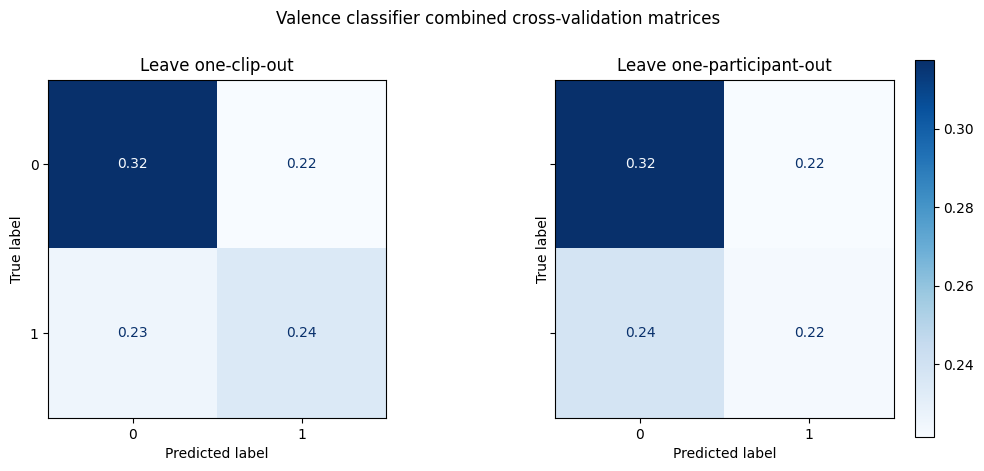

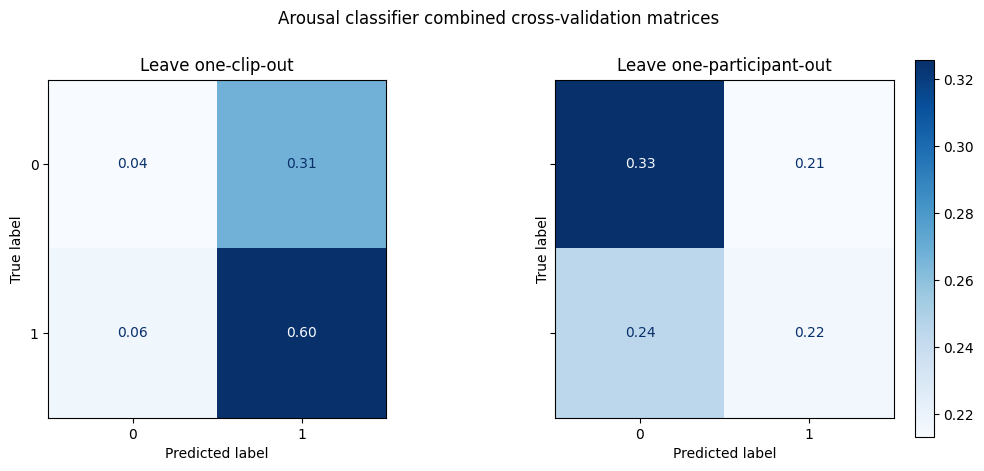

In [79]:
# Function for plotting confusion matrices for a classifier
def plot_confusion_matrices(cm_clip_out, cm_participant_out, title, normalize=False):
    # Create figure with subplots
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12, 5), sharey=True)
    
    # Overall title
    plt.suptitle(title)

    # Display confusion matrix for leave one clip out
    if normalize:
        disp = ConfusionMatrixDisplay(cm_clip_out/np.sum(cm_clip_out))
        disp.plot(ax=ax[0], values_format =".2f" , cmap="Blues") 
    else: 
        disp = ConfusionMatrixDisplay(cm_clip_out)
        disp.plot(ax=ax[0], values_format =".0f" , cmap="Blues") 
    disp.ax_.set_title("Leave one-clip-out")
    disp.im_.colorbar.remove()

    # Display confusion matrix for leave one participant out 
    if normalize: 
        disp = ConfusionMatrixDisplay(cm_participant_out/np.sum(cm_participant_out))
        disp.plot(ax=ax[1],values_format =".2f" , cmap="Blues")
    else: 
        disp = ConfusionMatrixDisplay(cm_participant_out)
        disp.plot(ax=ax[1], values_format =".0f" , cmap="Blues") 
    disp.ax_.set_title("Leave one-participant-out")
    plt.show()

# For the valence classifier
title = "Valence classifier combined cross-validation matrices"
plot_confusion_matrices(valence_clip_cm, valence_part_cm, title, normalize=True)

# For the arousal classifier
title = "Arousal classifier combined cross-validation matrices"
plot_confusion_matrices(arousal_clip_cm, arousal_part_cm, title, normalize=True)




#### d) Selecting the top 10 features

By adding up the importances the classifiers assign to each feature in our dataset and then sorting the features by their cumulative importance, we obtain a ranking of the most representative features for valence and arousal classfication. If we were limited to 10 features, we would choose the top 10 most representative features from our ranking. 

In [80]:
# get the sort order of the features for every classifier
importances = valence_clip_importances
ranking = np.argsort(-importances) # default sorts in ascending order, so we can invert by sorting the negative of the array

# Print top 10 features
top_features= all_features_names[ranking[:10]]

# Evaluate the model on top 10 features only
print("VALENCE CLASSFIER")
print("=================")
print()
print("Top 10 features:")
print(top_features)
print()
print("Running one clip out cross validation ...")

best_features = data[:,ranking[:10]]

valence_clip_metrics, valence_clip_cm, valence_clip_importances = use_random_forest_classifier(best_features, valence_labels, leave_clip_out, group_clips, n_estimators=30, criterion='gini', max_depth=5, min_samples_split= 2,max_features='auto', random_state= 42, class_weight='balanced_subsample', max_leaf_nodes=None, min_samples_leaf=1, min_impurity_decrease = 0.0)

print("Finsihed one clip out cross validation")
print()
print("F1 score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_clip_metrics[0]) , np.std(valence_clip_metrics[0]), np.amin(valence_clip_metrics[0]), np.amax(valence_clip_metrics[0])))

print("Precision:\t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_clip_metrics[1]) , np.std(valence_clip_metrics[1]), np.amin(valence_clip_metrics[1]), np.amax(valence_clip_metrics[1])))

print("Accuracy: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_clip_metrics[2]) , np.std(valence_clip_metrics[2]), np.amin(valence_clip_metrics[2]), np.amax(valence_clip_metrics[2])))

print("Recall score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_clip_metrics[3]) , np.std(valence_clip_metrics[3]), np.amin(valence_clip_metrics[3]), np.amax(valence_clip_metrics[3])))
print()


importances = valence_part_importances
ranking = np.argsort(-importances) # default sorts in ascending order, so we can invert by sorting the negative of the array
top_features= all_features_names[ranking[:10]]
print("Top 10 features:")
print(top_features)
print()
print("Running one participant out cross validation ...")

best_features = data[:,ranking[:10]]

valence_part_metrics, valence_part_cm, valence_part_importances = use_random_forest_classifier(best_features, valence_labels, leave_participant_out, group_participants,  n_estimators=10, criterion='gini', max_depth=5, min_samples_split= 2,max_features='auto', random_state= 42, class_weight='balanced_subsample', max_leaf_nodes=None, min_samples_leaf=1, min_impurity_decrease = 0.0)

print("Finsihed one participant out cross validation")
print()
print("F1 score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_part_metrics[0]) , np.std(valence_part_metrics[0]), np.amin(valence_part_metrics[0]), np.amax(valence_part_metrics[0])))

print("Precision:\t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_part_metrics[1]) , np.std(valence_part_metrics[1]), np.amin(valence_part_metrics[1]), np.amax(valence_part_metrics[1])))

print("Accuracy: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_part_metrics[2]) , np.std(valence_part_metrics[2]), np.amin(valence_part_metrics[2]), np.amax(valence_part_metrics[2])))

print("Recall score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(valence_part_metrics[3]) , np.std(valence_part_metrics[3]), np.amin(valence_part_metrics[3]), np.amax(valence_part_metrics[3])))
print()


print("AROUSAL CLASSFIER")
print("=================")
print()


importances = arousal_clip_importances
ranking = np.argsort(-importances) # default sorts in ascending order, so we can invert by sorting the negative of the array
top_features= all_features_names[ranking[:10]]
print("Top 10 features:")
print(top_features)
print()

best_features = data[:,ranking[:10]]
print("Running one clip out cross validation ...")

arousal_clip_metrics, arousal_clip_cm, arousal_clip_importances = use_random_forest_classifier(data, arousal_labels, leave_clip_out, group_clips, n_estimators=50, criterion='gini', max_depth=None, min_samples_split= 2,max_features='auto', random_state= 10, class_weight='balanced_subsample',min_samples_leaf=1, max_leaf_nodes=None, min_impurity_decrease = 0.0)

print("Finsihed one clip out cross validation")
print()
print("F1 score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_clip_metrics[0]) , np.std(arousal_clip_metrics[0]), np.amin(arousal_clip_metrics[0]), np.amax(arousal_clip_metrics[0])))

print("Precision:\t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_clip_metrics[1]) , np.std(arousal_clip_metrics[1]), np.amin(arousal_clip_metrics[1]), np.amax(arousal_clip_metrics[1])))

print("Accuracy: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_clip_metrics[2]) , np.std(arousal_clip_metrics[2]), np.amin(arousal_clip_metrics[2]), np.amax(arousal_clip_metrics[2])))

print("Recall score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_clip_metrics[3]) , np.std(arousal_clip_metrics[3]), np.amin(arousal_clip_metrics[3]), np.amax(arousal_clip_metrics[3])))
print()

importances = arousal_part_importances
ranking = np.argsort(-importances) # default sorts in ascending order, so we can invert by sorting the negative of the array
top_features= all_features_names[ranking[:10]]

print("Top 10 features:")
print(top_features)
print()
print("Running one participant out cross validation...")

best_features = data[:,ranking[:10]]

arousal_part_metrics, arousal_part_cm, arousal_part_importances = use_random_forest_classifier(data, valence_labels, leave_participant_out, group_participants, n_estimators=20, criterion='gini', max_depth=5, min_samples_split= 2,max_features='auto', random_state= 10, class_weight='balanced_subsample', max_leaf_nodes=5, min_samples_leaf=1, min_impurity_decrease = 0.0)

print("Finsihed one participant out cross validation")
print()
print("F1 score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_part_metrics[0]) , np.std(arousal_part_metrics[0]), np.amin(arousal_part_metrics[0]), np.amax(arousal_clip_metrics[0])))

print("Precision:\t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_part_metrics[1]) , np.std(arousal_part_metrics[1]), np.amin(arousal_part_metrics[1]), np.amax(arousal_part_metrics[1])))

print("Accuracy: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_part_metrics[2]) , np.std(arousal_part_metrics[2]), np.amin(arousal_part_metrics[2]), np.amax(arousal_part_metrics[2])))

print("Recall score: \t mean: {:.2f} \t std: {:.2f} \t min {:.2f} \t max {:.2f}". format(np.mean(arousal_part_metrics[3]) , np.std(arousal_part_metrics[3]), np.amin(arousal_part_metrics[3]), np.amax(arousal_part_metrics[3])))
print()



VALENCE CLASSFIER

Top 10 features:
['V_def_LLC_mean' 'V_def_LLC_stdev' 'def_LC_stdev' 'V_def_RLC_mean'
 'stdev_res' 'V_def_LLC_skew' 'H_def_RLC_stdev' 'CH5_mean' 'def_LC_mean'
 'CH8_d_mean']

Running one clip out cross validation ...


ValueError: too many values to unpack (expected 3)

#### e) Zero Rule baseline comparison

The Zero Rule algorithm always predicts the majority class in the dataset. If we want a direct comparison between the metrics of our classifier and the ZeroR algorithm, we need to apply the ZeroR algorithm in the same cross validation scheme and compare average metrics. 

In [ ]:
# Functions to apply ZeroR algorithm 

def zero_rule_classification(y_train, test):
    '''
    Finds majority label and applies it as prediction to a test set
    '''
    # Find the majority label
    label, counts = np.unique(y_train, return_counts=True)
    maj_label = label[np.argmax(counts)]
    
    # Apply prediction
    y_pred = int(maj_label)*np.ones(len(test))

    return y_pred

def zero_rule_cv(data, labels, cross_val_scheme, group):
    '''
    Applies ZeroR alogorithm to a group cross validation scheme
    '''
    
    # Reset metrics:
    f1 = np.zeros((0,1)) 
    precision = np.zeros((0,1))
    accuracy = np.zeros((0,1)) 
    recall = np.zeros((0,1))
    confusion_m= np.zeros((2,2))

    for train_idx, test_idx in cross_val_scheme.split(X=data, y=labels, groups=group):
    
        # Train - test split
        X_train, X_test = data[train_idx], data[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        # Prediction
        y_pred = zero_rule_classification(y_train, X_test)

        # Metrics
        f1 = np.append(f1, f1_score(y_test, y_pred))
        precision = np.append(precision, precision_score(y_test, y_pred))
        accuracy = np.append(accuracy, accuracy_score(y_test, y_pred))
        recall = np.append(recall, recall_score(y_test, y_pred))
        confusion_m += confusion_matrix(y_test, y_pred)
    
    # Average metrics 
    f1 = np.mean(f1)
    precision =  np.mean(precision)
    accuracy = np.mean(accuracy)
    recall =  np.mean(recall)

    metrics = np.array([f1, precision, accuracy, recall]) 

    return metrics, confusion_m

# All data
data = all_features[:,2:]

# Labels
valence_labels = valence_dist
arousal_labels = arousal_dist

# Groups for Leave one out validation
group_clips = all_features[:,1]
group_participants = all_features[:,0]

# Leave one clip out cross-validation 
leave_clip_out = LeaveOneGroupOut()
# Leave one participant out cross-validation 
leave_participant_out = LeaveOneGroupOut()

print("VALENCE ZERO-R CLASSFIER")
print("=================")
print()

# leave clip out
valence_clip_zr, valence_clip_cm_zr  = zero_rule_cv(data, valence_labels, leave_clip_out, group_clips) 
print()
print("F1 score: {:.2f}".format(valence_clip_zr[0]))
print("Precision score: {:.2f}".format(valence_clip_zr[1]))
print("Accuracy score: {:.2f}".format(valence_clip_zr[2]))
print("Recall score: {:.2f}".format(valence_clip_zr[3]))

# leave participant out 
valence_part_zr, valence_part_cm_zr  = zero_rule_cv(data, valence_labels, leave_participant_out, group_participants) 
print()
print("F1 score: {:.2f}".format(valence_part_zr[0]))
print("Precision score: {:.2f}".format(valence_part_zr[1]))
print("Accuracy score: {:.2f}".format(valence_part_zr[2]))
print("Recall score: {:.2f}".format(valence_part_zr[3]))
print()

print("AROUSAL ZERO-R CLASSFIER")
print("=================")
print()
# leave clip out
arousal_clip_zr, arousal_clip_cm_zr  = zero_rule_cv(data, arousal_labels, leave_clip_out, group_clips)
print("F1 score: {:.2f}".format(arousal_clip_zr[0]))
print("Precision score: {:.2f}".format(arousal_clip_zr[1]))
print("Accuracy score: {:.2f}".format(arousal_clip_zr[2]))
print("Recall score: {:.2f}".format(arousal_clip_zr[3]))
print()

# leave participant out 
arousal_part_zr, arousal_part_cm_zr  = zero_rule_cv(data, arousal_labels, leave_participant_out, group_participants) 
print("F1 score: {:.2f}".format(arousal_part_zr[0]))
print("Precision score: {:.2f}".format(arousal_part_zr[1]))
print("Accuracy score: {:.2f}".format(arousal_part_zr[2]))
print("Recall score: {:.2f}".format(arousal_part_zr[3]))
print()

# For the valence classifier
title = "Valence classifier combined cross-validation matrices"
plot_confusion_matrices(valence_clip_cm_zr, valence_part_cm_zr, title, normalize=True)

# For the arousal classifier
title = "Arousal classifier combined cross-validation matrices"
plot_confusion_matrices(arousal_clip_cm_zr, arousal_part_cm_zr, title, normalize=True)
